<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparations" data-toc-modified-id="Preparations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparations</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Loading-Pretrained" data-toc-modified-id="Loading-Pretrained-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Loading Pretrained</a></span></li></ul></li><li><span><a href="#Quantitative" data-toc-modified-id="Quantitative-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quantitative</a></span></li><li><span><a href="#Computational-Efficiency" data-toc-modified-id="Computational-Efficiency-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Computational Efficiency</a></span></li><li><span><a href="#Qualitative" data-toc-modified-id="Qualitative-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Qualitative</a></span><ul class="toc-item"><li><span><a href="#Comparing-GridedCCP-and-SelfAttnCNP" data-toc-modified-id="Comparing-GridedCCP-and-SelfAttnCNP-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Comparing GridedCCP and SelfAttnCNP</a></span></li><li><span><a href="#The-Need-for-Translation-Equivariance" data-toc-modified-id="The-Need-for-Translation-Equivariance-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>The Need for Translation Equivariance</a></span></li></ul></li><li><span><a href="#Qualitative-Results-under-Different-Settings" data-toc-modified-id="Qualitative-Results-under-Different-Settings-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Qualitative Results under Different Settings</a></span></li><li><span><a href="#Understanding-the-first-Layer" data-toc-modified-id="Understanding-the-first-Layer-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Understanding the first Layer</a></span></li><li><span><a href="#Loosing-Translation-Equivariance-with-Large-Receptive-Field" data-toc-modified-id="Loosing-Translation-Equivariance-with-Large-Receptive-Field-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Loosing Translation Equivariance with Large Receptive Field</a></span></li><li><span><a href="#Will-Not-Mention-But-Interesting" data-toc-modified-id="Will-Not-Mention-But-Interesting-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Will Not Mention But Interesting</a></span></li></ul></div>

# ICLR Results

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = True # can also be set in the trainer

## Preparations

In [2]:
cd ..

/private/home/yannd/projects/NPF


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

## Dataset 

In [5]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

In [5]:
celeba32_train, celeba32_test = train_dev_split(get_dataset("celeba32")(), dev_size=0.1, is_stratify=False)
celeba_train, celeba_test = train_dev_split(get_dataset("celeba")(), dev_size=0.1, is_stratify=False)
celeba64_train, celeba64_test = train_dev_split(get_dataset("celeba64")(), dev_size=0.1, is_stratify=False)
svhn_train, svhn_test = get_dataset("svhn")(split="train"), get_dataset("svhn")(split="test")
mnist_train, mnist_test = get_dataset("mnist")(split="train"), get_dataset("mnist")(split="test")
zs_mmnist_train, zs_mmnist_test = get_dataset("zs-multi-mnist")(split="train"), get_dataset("zs-multi-mnist")(split="test")

# celeba64 not fully trained yet
train_datasets_32 = {"mnist":mnist_train, "celeba32":celeba32_train, "svhn":svhn_train}
test_datasets_32 = {"mnist":mnist_test, "celeba32":celeba32_test, "svhn":svhn_test}
train_datasets_64 = {"celeba64":celeba64_train, "zs-multi-mnist":zs_mmnist_train}
test_datasets_64 = {"celeba64":celeba64_test, "zs-multi-mnist":zs_mmnist_test}
train_datasets = {"celeba":celeba_train}
test_datasets = {"celeba":celeba_test}

data_names = {"mnist":"MNIST",
             "celeba64":"CelebA 64x64",
             "celeba32":"CelebA 32x32",
              "celeba":"Unscaled CelebA",
             "zs-multi-mnist":"Zero Shot Multi-MNIST",
              "svhn":"SVHN"
             }

Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../../../data/train_32x32.mat
Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../../../data/test_32x32.mat


INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...


In [6]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

In [7]:
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

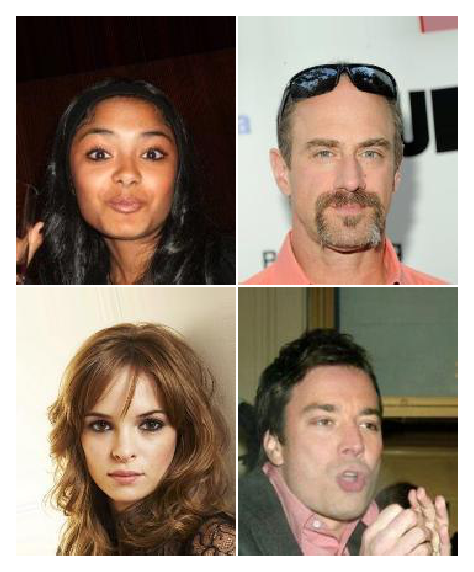

In [8]:
plot_dataset_samples_imgs(celeba_test, figsize=(9,5))

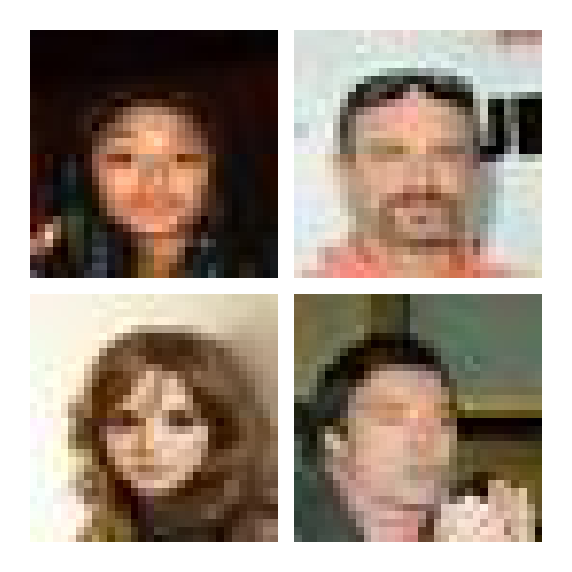

In [9]:
plot_dataset_samples_imgs(celeba32_test, figsize=(9,5))

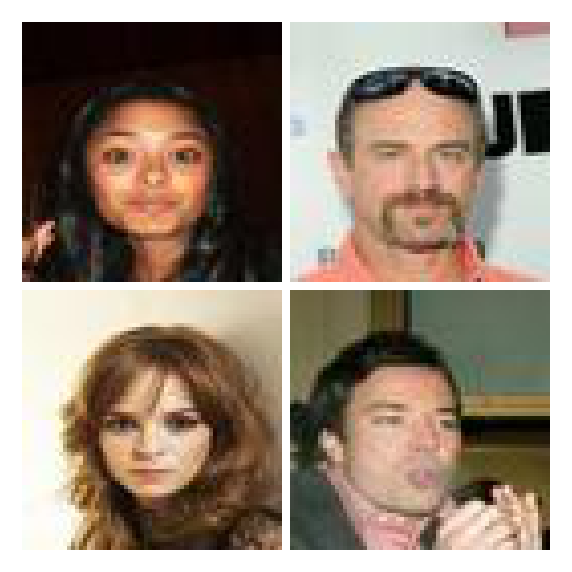

In [10]:
plot_dataset_samples_imgs(celeba64_test, figsize=(9,5))

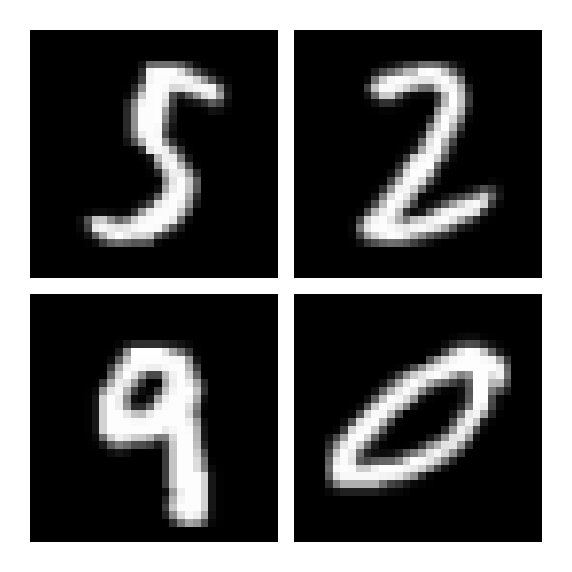

In [11]:
plot_dataset_samples_imgs(mnist_test, figsize=(9,5))

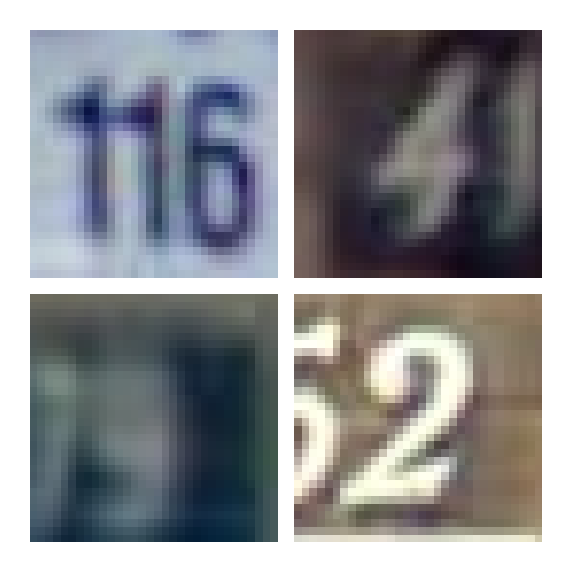

In [12]:
plot_dataset_samples_imgs(svhn_test, figsize=(9,5))

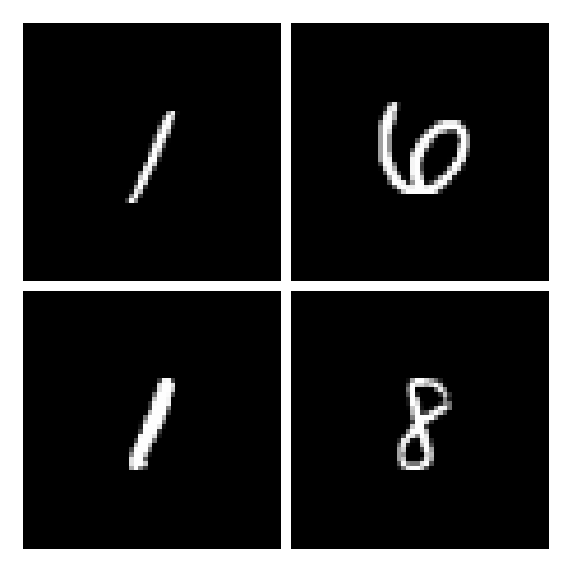

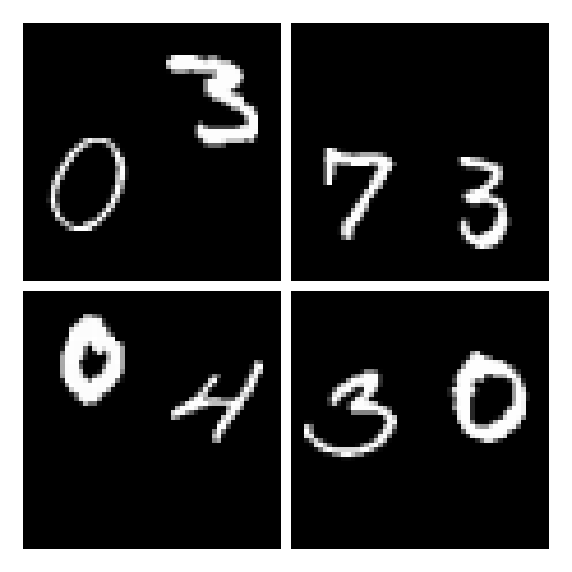

In [13]:
plot_dataset_samples_imgs(zs_mmnist_train, figsize=(9,5))
plot_dataset_samples_imgs(zs_mmnist_test, figsize=(9,5))

### Models

In [14]:
X_DIM = 2  # 2D spatial input 

In [15]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

In [16]:
from train_imgs import get_model

# models that take into account the grid
models_grided_64 = {}
models_grided_64["GridedCCP"] = get_model("GridedCCP", img_shape=(64,64))
models_grided_64["GridedCCP_large"] = get_model("GridedCCP", 
                                                n_blocks=7, kernel_size=9, init_kernel_size=11, img_shape=(64,64), n_conv_layers=2)
#models_grided_64["GridedCCP_rbf"] = get_model("GridedCCP", is_rbf=True, img_shape=(64,64))


models_grided_32 = {}
models_grided_32["GridedCCP"] = get_model("GridedCCP",  img_shape=(32,32))
models_grided_32["GridedCCP_large"] = get_model("GridedCCP", n_blocks=7, kernel_size=9, init_kernel_size=11, img_shape=(32, 32), n_conv_layers=2)
#models_grided_32["GridedCCP_rbf"] = get_model("GridedCCP", is_rbf=True, img_shape=(32, 32))

models_general = {}
models_general["SelfAttnCNP"] = get_model("SelfAttnCNP")

In [17]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

In [18]:
from utils.helpers import count_parameters
count_parameters(add_y_dim(models_grided_32, train_datasets_32)["celeba32"]["GridedCCP"]())

111135

### Loading Pretrained

In [19]:
def merge_dicts(dicts):
    out = dict()
    for d in dicts:
        out.update(d)
    return out

In [34]:
chckpnt_dirname="results/iclr_bug/"

In [35]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

import os
import contextlib

kwargs = dict(chckpnt_dirname=chckpnt_dirname, 
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             patience=10,
             batch_size=16,
             seed=123,
             runs=6)

# Takes 1-3 mins
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f): # don't print
    trainers_grided_64 = train_models(train_datasets_64, 
                                     add_y_dim(models_grided_64, train_datasets_64),
                                      NeuralProcessLoss,
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True),
                                     **kwargs) 

    trainers_grided_32 = train_models(train_datasets_32, 
                                     add_y_dim(models_grided_32, train_datasets_32),
                                      NeuralProcessLoss,
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True),
                                     **kwargs) 


    train_datasets_all = merge_dicts([train_datasets_32, train_datasets_64])
    train_datasets_all.pop("celeba64")

    trainers_general = train_models(train_datasets_all, 
                                     add_y_dim(models_general, train_datasets_all),
                                     NeuralProcessLoss,
                                     iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
                                     **kwargs)

In [36]:
models_grided_big = {}
models_grided_big["GridedCCP_large"] = get_model("GridedCCP", n_blocks=7, kernel_size=9, 
                                                 init_kernel_size=11, img_shape=(32, 32),
                                                n_conv_layers=2)

In [37]:
trainers_grided_big = train_models(train_datasets, 
                                     add_y_dim(models_grided_big, train_datasets),
                                      NeuralProcessLoss,
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True),
                                     chckpnt_dirname=chckpnt_dirname, 
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             patience=10,
             batch_size=16,
             seed=123) 


--- Loading celeba/GridedCCP_large/run_0 ---



FileNotFoundError: [Errno 2] No such file or directory: 'results/iclr_bug/celeba/GridedCCP_large/run_0/history.json'

# Core Paper

## Quantitative

In [38]:
from utils.helpers import load_all_results

In [39]:
results=load_all_results(chckpnt_dirname).groupby(["Data", "Model"]).agg(["count","mean","std"]).reset_index()

In [40]:
results.pivot_table(values="LogLike", index="Model", columns="Data")["mean"]

/private/home/yannd/.conda/envs/neuralproc/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


Data,celeba32,celeba64,mnist,svhn,zs-multi-mnist
Model,,,,,
GridedCCP,3.291349,3.696701,1.239416,3.945448,0.561759
GridedCCP_large,3.389923,3.728846,1.265034,3.967863,0.860241
SelfAttnCNP,3.182620,NaN,1.076328,3.943764,-0.828911


Interesting : not a big difference with RBF, but improves translation equivariance.

In [41]:
results.pivot_table(values="LogLike", index="Model", columns="Data")["std"]

Data,celeba32,celeba64,mnist,svhn,zs-multi-mnist
Model,,,,,
GridedCCP,0.026735,0.016904,0.004992,0.011798,0.267495
GridedCCP_large,0.018195,0.010411,0.005486,0.016062,0.116494
SelfAttnCNP,0.020023,NaN,0.043303,0.017116,0.075716


## Computational Efficiency

In [42]:
trainers = merge_dicts([trainers_grided_64, trainers_grided_32, trainers_general])

In [43]:
from utils.train import _best_loss
import pandas as pd
from utils.helpers import count_parameters

def get_efficiency(trainers):
    out = []
    for name, trainer in trainers.items():
        _, best_epoch = _best_loss(trainer)
        l = [epoch_hist['dur'] for epoch_hist in trainer.history]
        out.append(name.split("/")+[best_epoch, sum(l)/len(l), count_parameters(trainer.module_)])
    return pd.DataFrame(out, columns=["Data", "Model", "Runs", "Convergence Epoch", "Time Per Epoch", "N. Param"])

In [44]:
get_efficiency(trainers).groupby(["Data", "Model"]).median().reset_index()

,Data,Model,Convergence Epoch,Time Per Epoch,N. Param
0,celeba32,GridedCCP,14.5,1261.376662,200095.0
1,celeba32,GridedCCP_large,14.5,1667.177562,400503.0
2,celeba32,SelfAttnCNP,17.5,1207.851017,410214.0
3,celeba64,GridedCCP,27.5,1116.887059,220671.0
4,celeba64,GridedCCP_large,24.5,2195.678420,400503.0
5,mnist,GridedCCP,23.5,153.520762,199221.0
6,mnist,GridedCCP_large,23.5,308.210867,399485.0
7,mnist,SelfAttnCNP,16.5,305.880912,409890.0
8,svhn,GridedCCP,21.0,192.003489,200095.0
9,svhn,GridedCCP_large,23.0,364.502795,400503.0


TO-DO: 
- Add Memory Usage
- Note that Slef Attn for zs-multi-mnist uses batch size only 6 because of memory

## Qualitative

In [45]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE, points_to_grid

### Comparing GridedCCP and SelfAttnCNP

In [46]:
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde

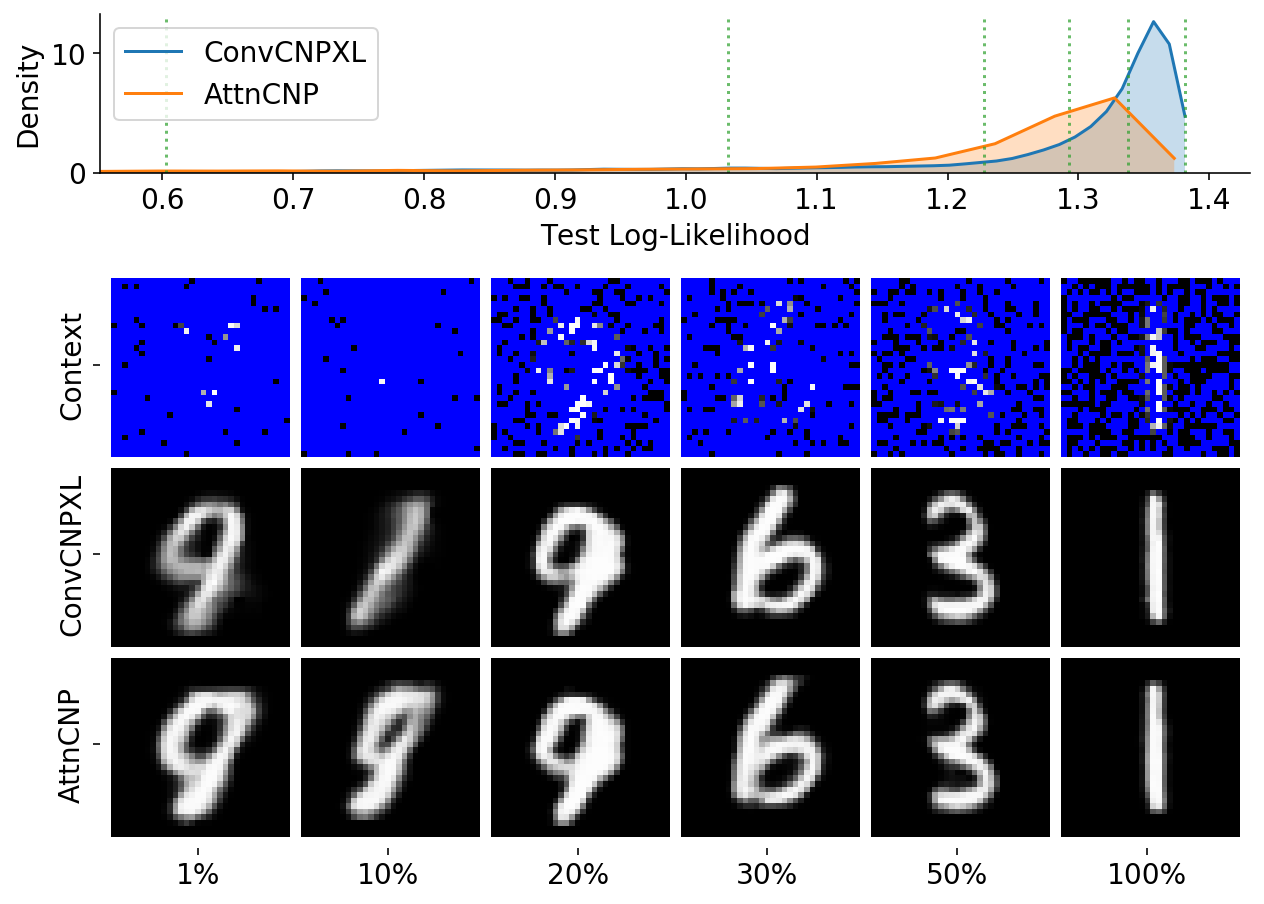

In [67]:
data_name = "mnist"
test_data = mnist_test

test_loglike = plot_qualitative_with_kde(["ConvCNPXL", trainers_grided_32['{}/GridedCCP_large/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["AttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         figsize=(9,7),
                                         percentiles=[1,10,20,30,50,100],
                                         height_ratios=[1,5],
                                         is_smallest_xrange=True,
                                         font_size=14,
                                         h_pad=-2)

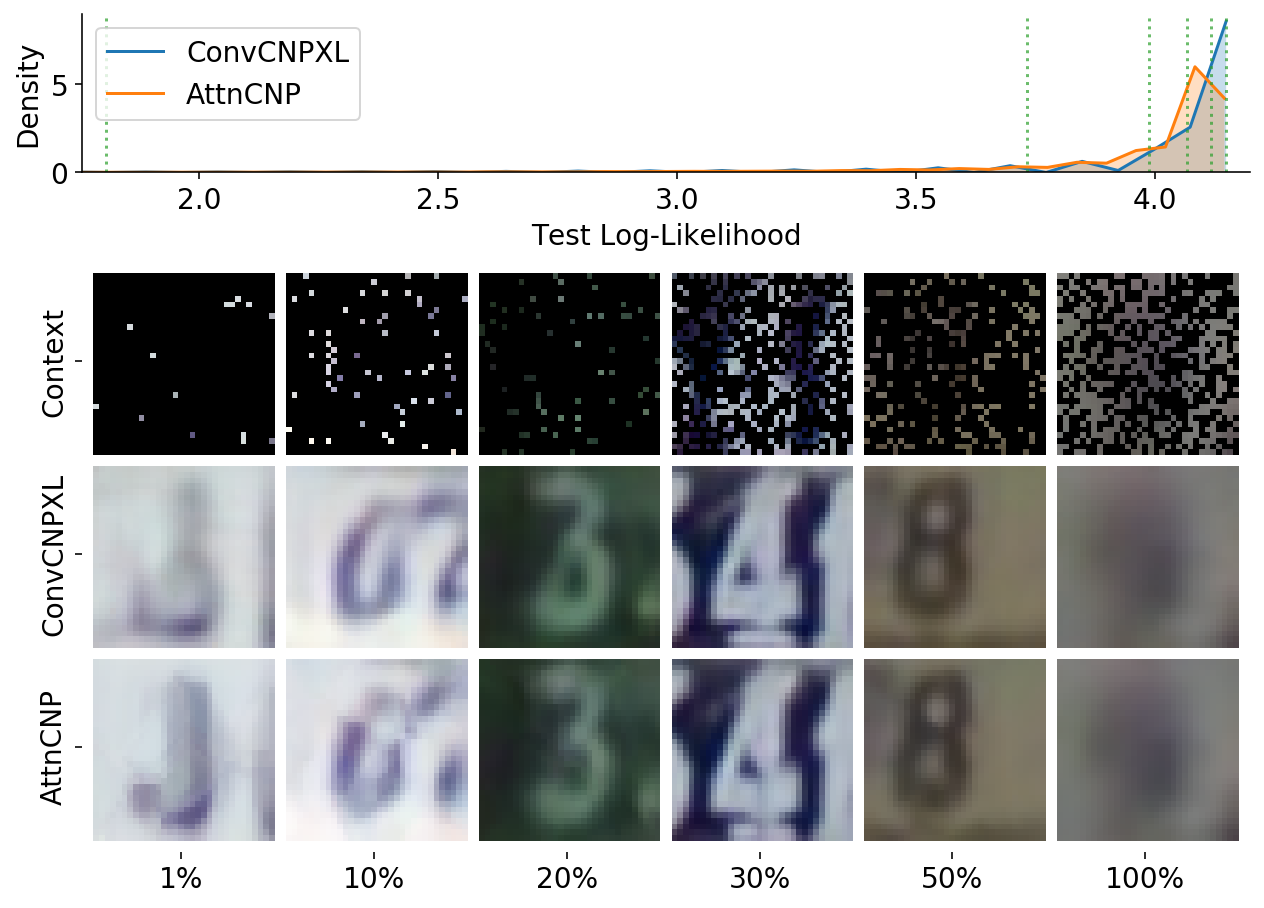

In [65]:
data_name = "svhn"
test_data = svhn_test

test_loglike = plot_qualitative_with_kde(["ConvCNPXL", trainers_grided_32['{}/GridedCCP_large/run_4'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["AttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         figsize=(9,7),
                                         percentiles=[1,10,20,30,50,100],
                                         height_ratios=[1,5],
                                         is_smallest_xrange=True,
                                         h_pad=-2)

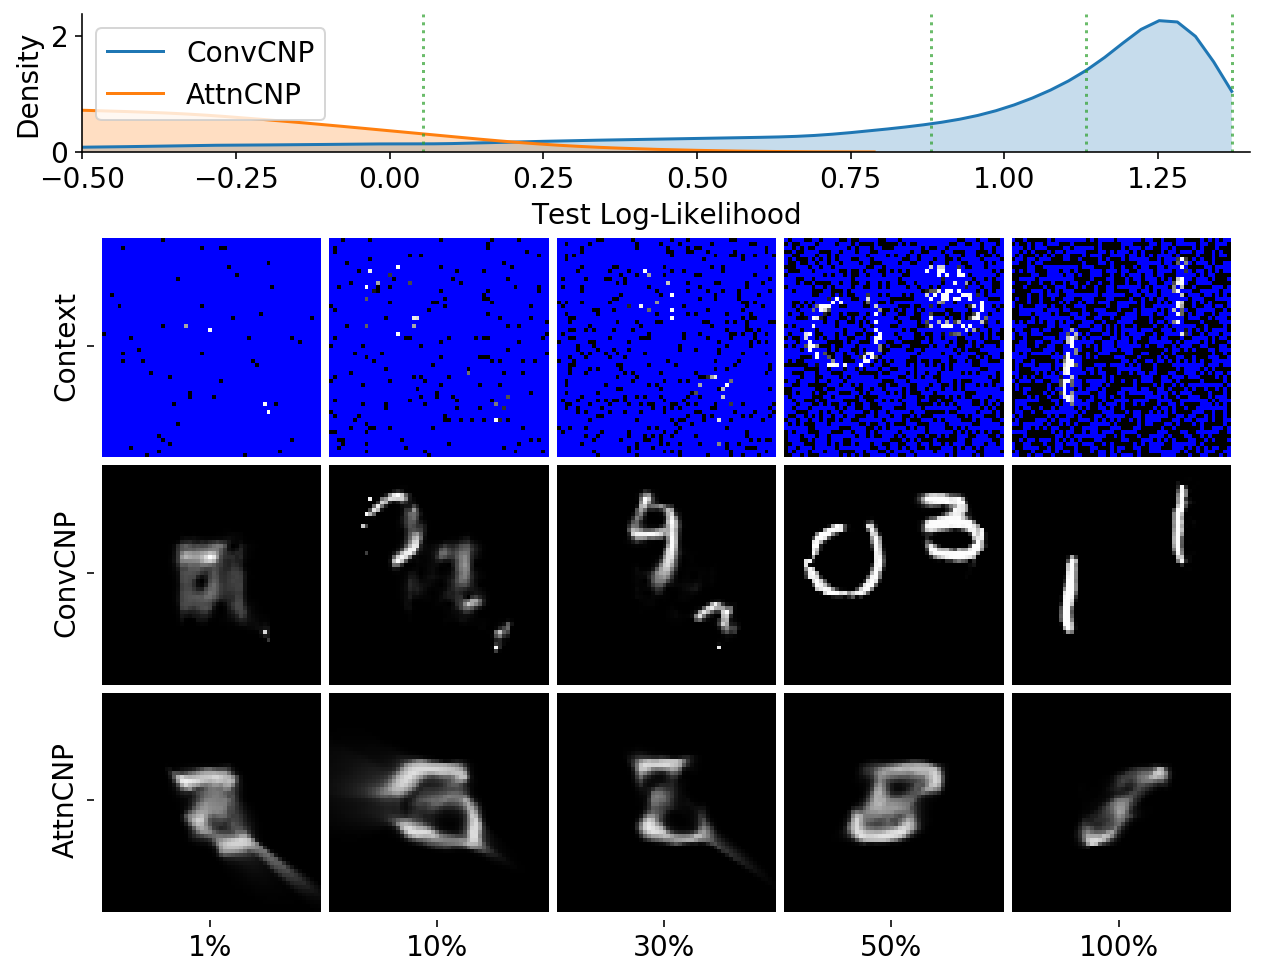

In [47]:
data_name = "zs-multi-mnist"
test_data = zs_mmnist_test

test_loglike = plot_qualitative_with_kde(["ConvCNP", trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["AttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         figsize=(9, 7),
                                         percentiles=[1,10,30,50,100],
                                        height_ratios=[1,5],
                                         x_lim={"left":-0.5, "right":1.4},
                                         h_pad=0)

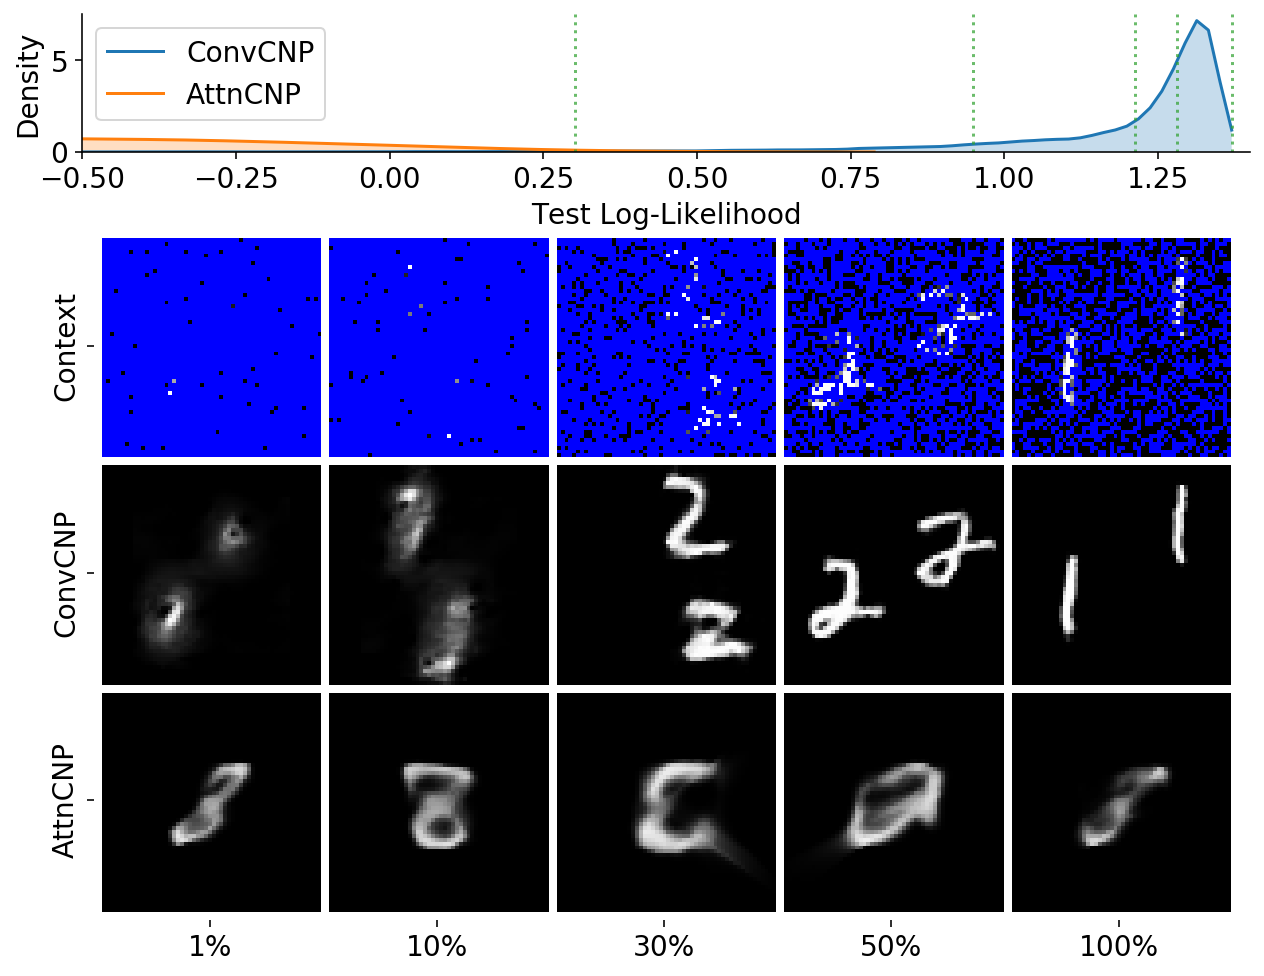

In [67]:
data_name = "zs-multi-mnist"
test_data = zs_mmnist_test

test_loglike = plot_qualitative_with_kde(["ConvCNP", trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["AttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         figsize=(9, 7),
                                         percentiles=[1,10,30,50,100],
                                        height_ratios=[1,5],
                                         x_lim={"left":-0.5, "right":1.4},
                                         h_pad=0)

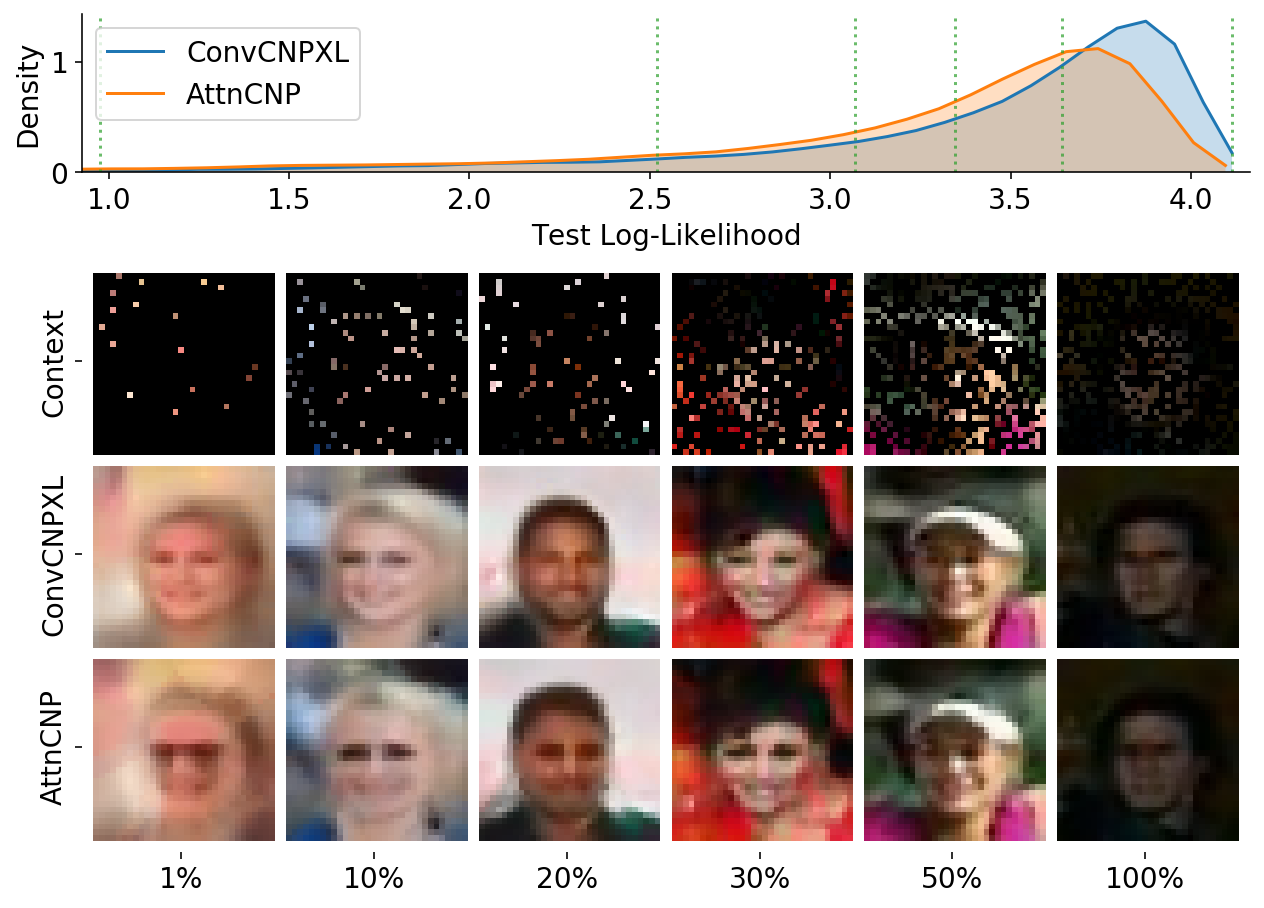

In [58]:
data_name = "celeba32"
test_data = celeba32_test

test_loglike = plot_qualitative_with_kde(["ConvCNPXL", trainers_grided_32['{}/GridedCCP_large/run_4'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["AttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         figsize=(9,7),
                                         percentiles=[1,10,20,30,50,100],
                                         height_ratios=[1,5],
                                         is_smallest_xrange=True,
                                         h_pad=-2)

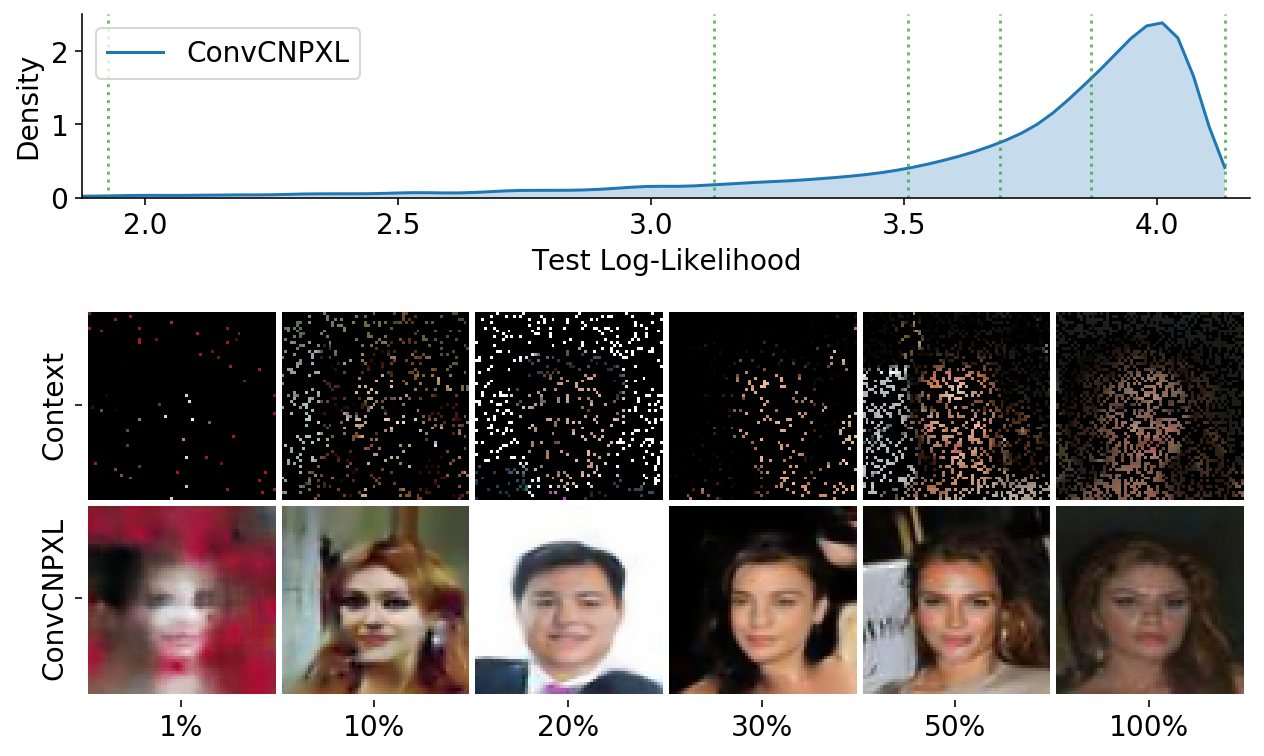

In [83]:
data_name = "celeba64"
test_data = celeba64_test

test_loglike = plot_qualitative_with_kde(["ConvCNPXL", trainers_grided_64['{}/GridedCCP_large/run_0'.format(data_name)]],
                                         test_data,
                                         figsize=(9,7),
                                         percentiles=[1,10,20,30,50,100],
                                         height_ratios=[1,5],
                                         is_smallest_xrange=True,
                                         h_pad=-4)

### The Need for Translation Equivariance

TO-DO: 
- Test the Grided CCP on real image

# Appendix

In [49]:
trainers_grided = merge_dicts([trainers_grided_64, trainers_grided_32, trainers_general, trainers_grided_big])

## Qualitative Results under Different Settings

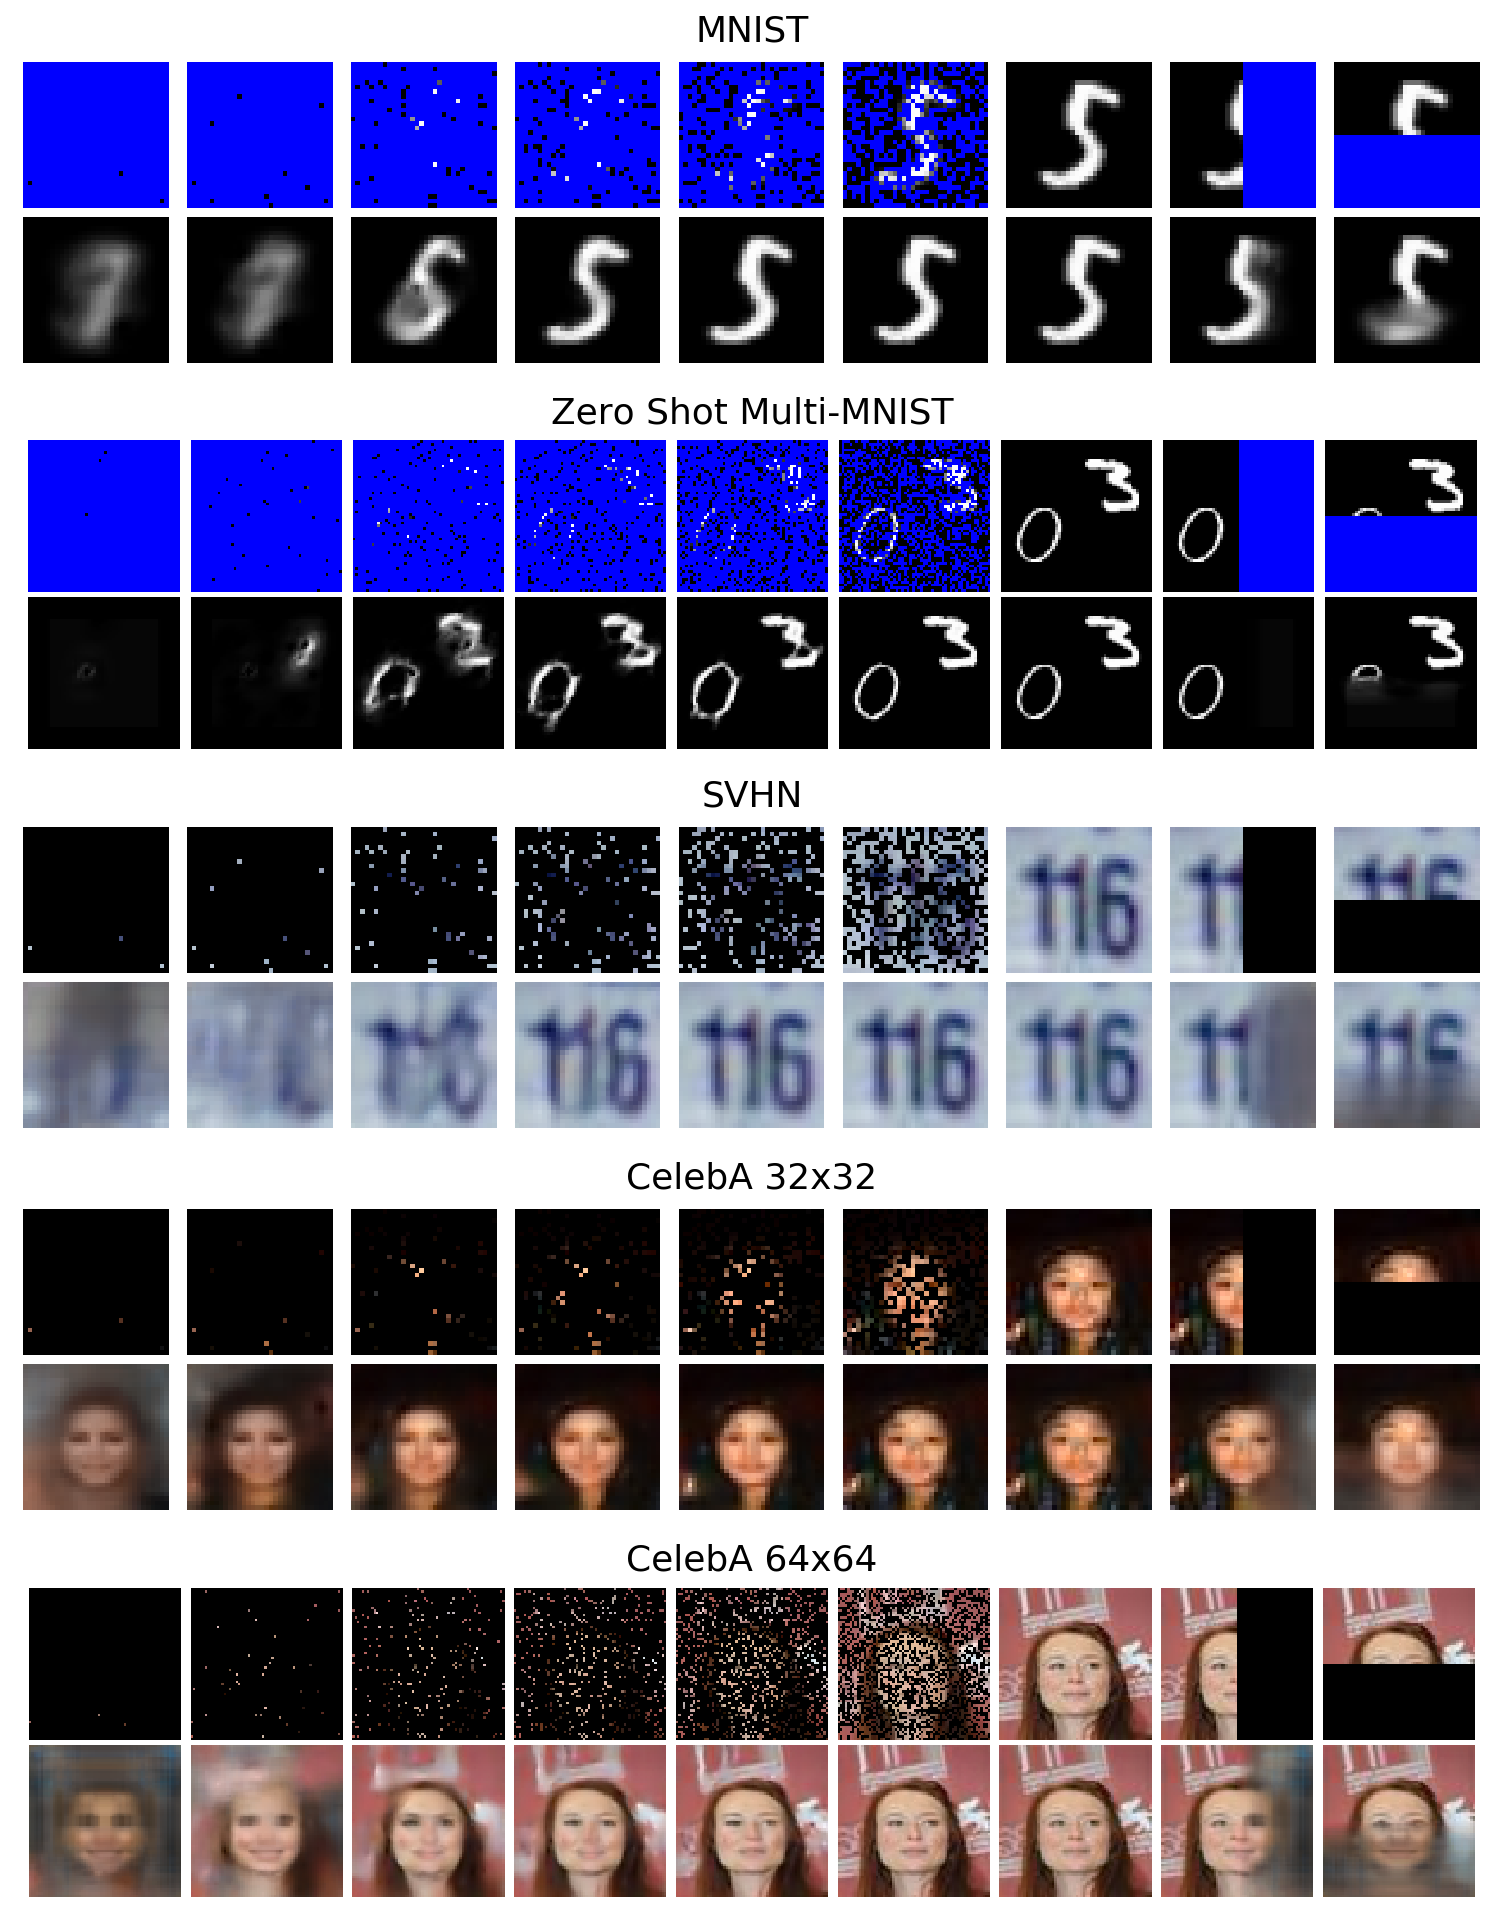

In [129]:
# 3 pixel, 1%, 5%, 10%, 20%, 30%, 50%, 100%, Half Bottom, Half Right
# Rows "mnist", "celeba32", "celeba64", "zs-multi-mnist", "svhn"
# use small model for "zs-multi-mnist"

context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

data_models = [(mnist_test, "mnist/GridedCCP_large"),
               (zs_mmnist_test, "zs-multi-mnist/GridedCCP"), # use the translation equivariant one
               (svhn_test, "svhn/GridedCCP_large"),
               (celeba32_test, "celeba32/GridedCCP_large"),
               (celeba64_test, "celeba64/GridedCCP_large")
              ]

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

## Understanding the first Layer

First Layer of small GridedCCP


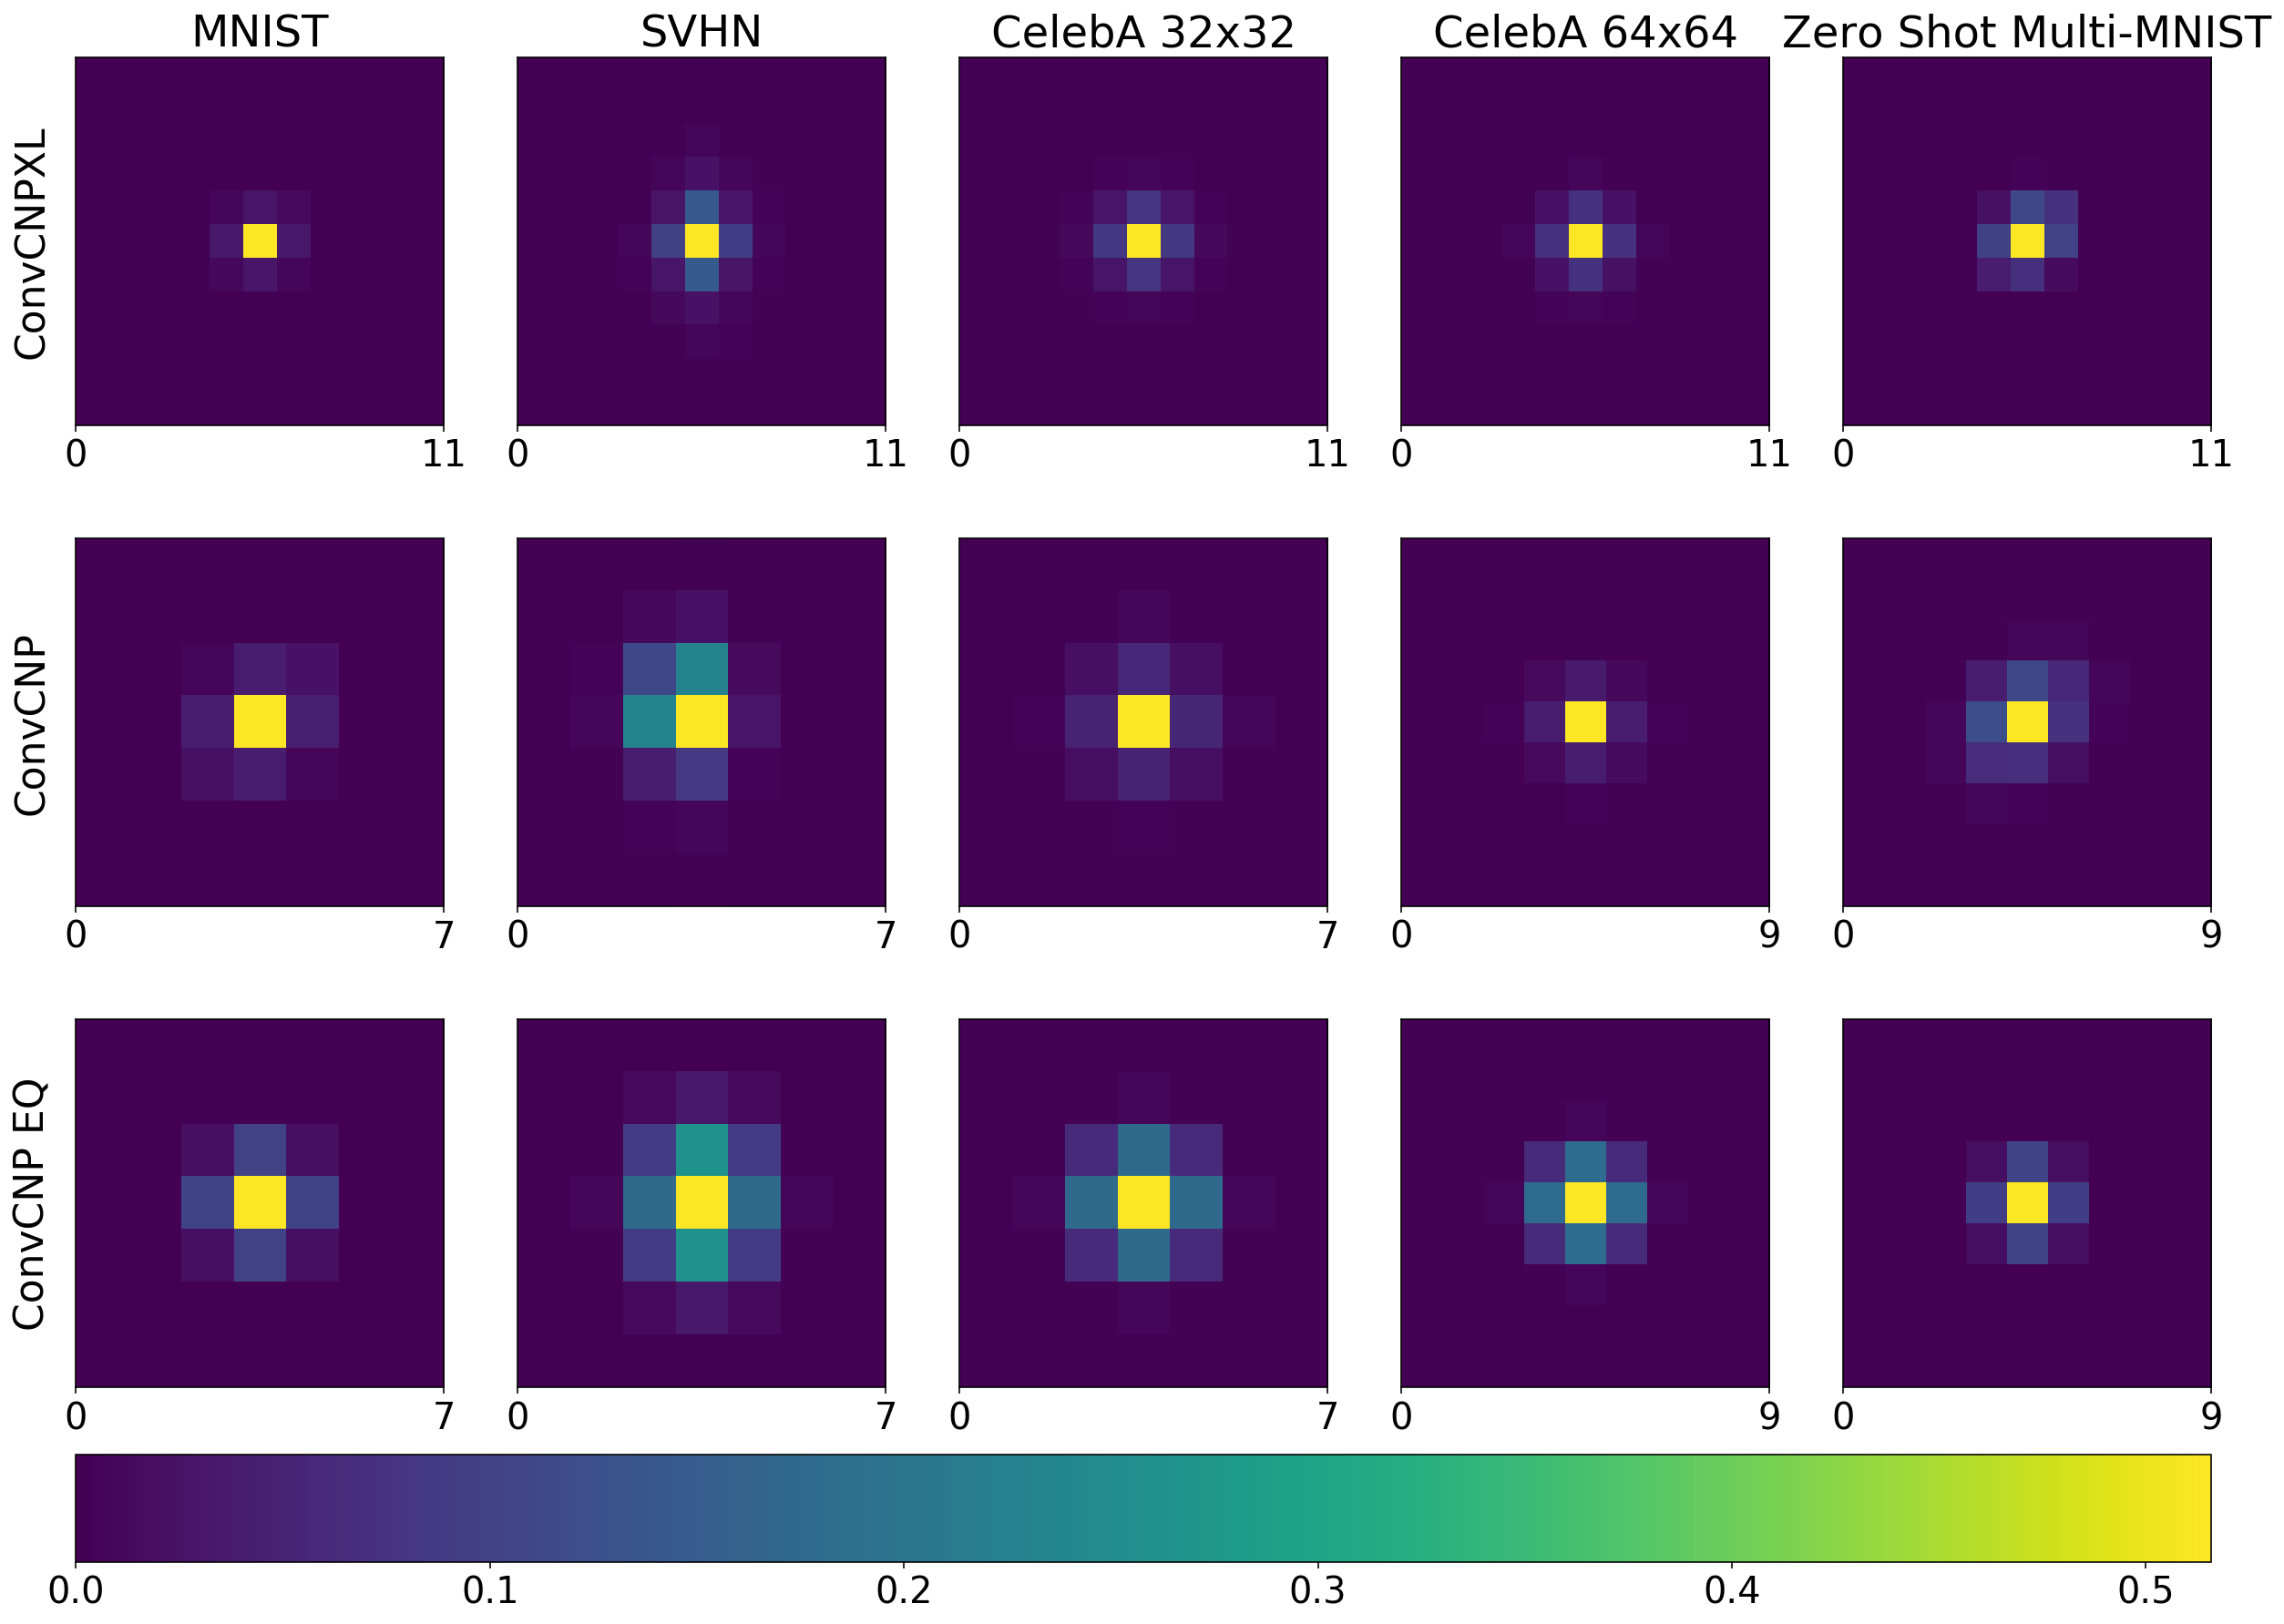

In [274]:


dataset = ["mnist", "svhn", "celeba32", "celeba64", "zs-multi-mnist"]
fig, axes = plt.subplots(3,len(dataset), figsize=(21,17))

plt.rcParams.update({"font.size": 20})

for i, d in enumerate(dataset):
    for j, name in enumerate(["GridedCCP_large", "GridedCCP", "GridedCCP_rbf"]):
        # use abs because I force positive weights in my implementation
        txt = '{}/{}/run_0'
        if name == "GridedCCP_rbf":
            conv=trainers_grided[txt.format(d, name)].module_.conv
            marginal_x = torch.softmax(conv.exponent * conv.weights_x, dim=0)
            marginal_y = torch.softmax(conv.exponent * conv.weights_y, dim=0).T
            weights_layer_1 = marginal_x @ marginal_y
        else:
            try:
                weights_layer_1 = trainers_grided[txt.format(d, name)].module_.conv.weight.squeeze(1)[0].abs()
            except:
                weights_layer_1 = trainers_grided[txt.format(d, name)].module_.conv.weight.squeeze(1)[0].abs()
        im = axes[j, i].imshow(weights_layer_1.detach().numpy())
        if j == 0:
            axes[j, i].set_title(data_names[d])
        axes[j, i].set_xticks([-0.5, weights_layer_1.shape[0]-0.5])
        axes[j, i].set_xticklabels([0, weights_layer_1.shape[0]])
        axes[j, i].set_yticks([])
    
colorbar=fig.colorbar(im,  orientation="horizontal", ax=axes.ravel().tolist(), pad=0.04)

for ax, row in zip(axes[:,0], ["ConvCNPXL", "ConvCNP", "ConvCNP EQ"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation="vertical", 
                fontsize=22)
    
print("First Layer of small GridedCCP")

We see that it when it is not translation equivariant it uses a non RBF like first layer.

## Loosing Translation Equivariance with Large Receptive Field

When using a large receptuve field in our datasets, the mdoel is able to learn to not be translation equivariant.

In [41]:
context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

data_models = [(mnist_test, "mnist/GridedCCP"),
               (zs_mmnist_test, "zs-multi-mnist/GridedCCP"), # use the translation equivariant one
               (svhn_test, "svhn/GridedCCP"),
               (celeba32_test, "celeba32/GridedCCP"),
               (celeba64_test, "celeba64/GridedCCP")
              ]



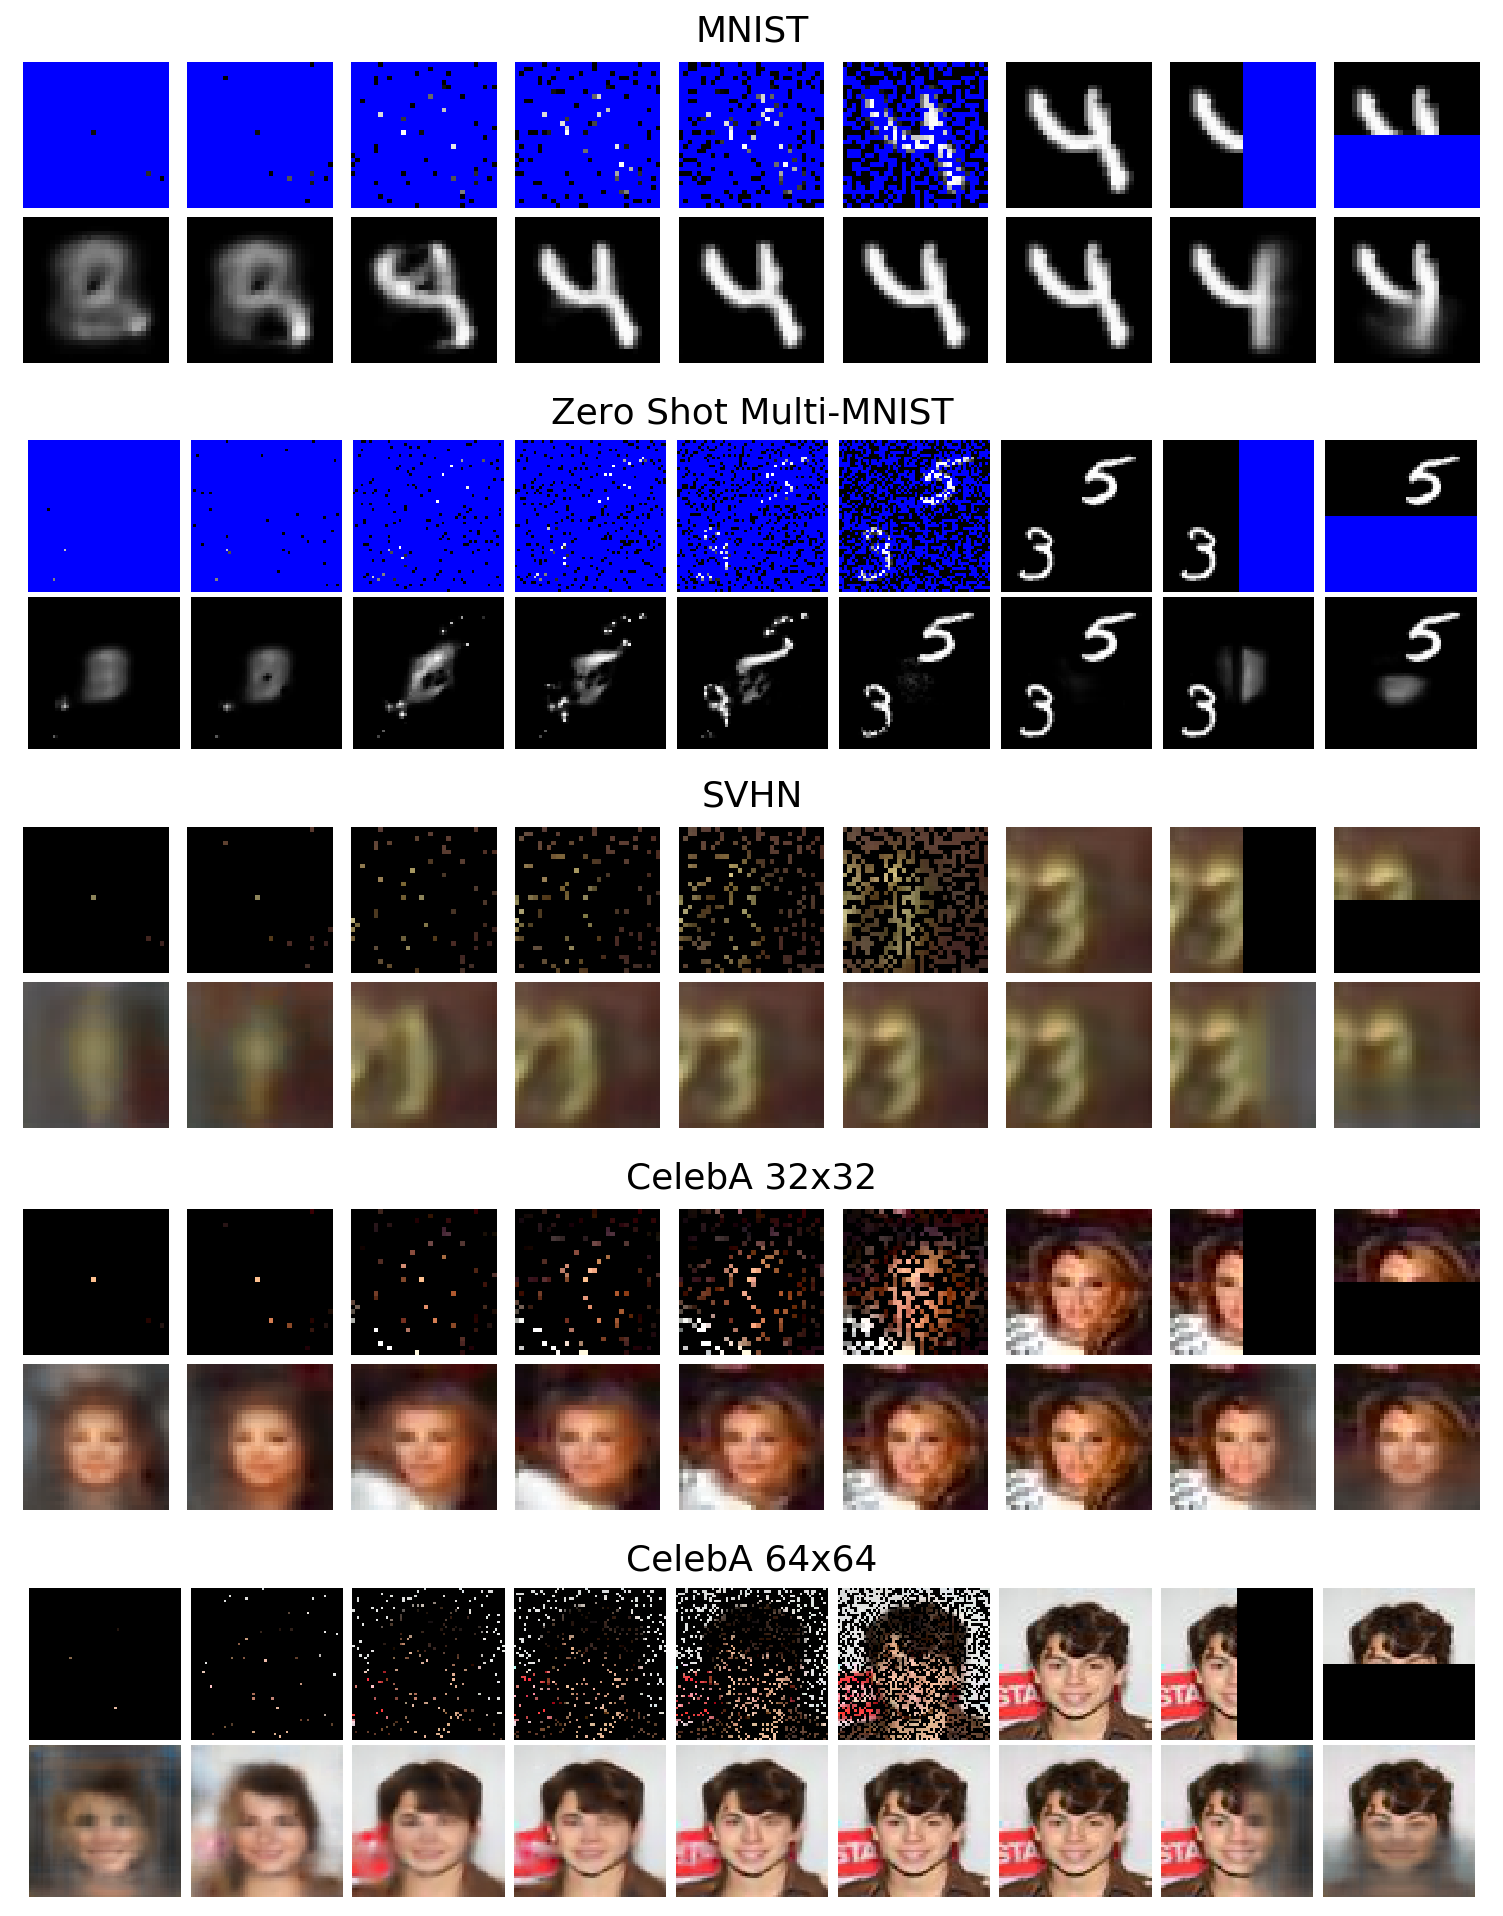

In [42]:
# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}_large/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=1 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)




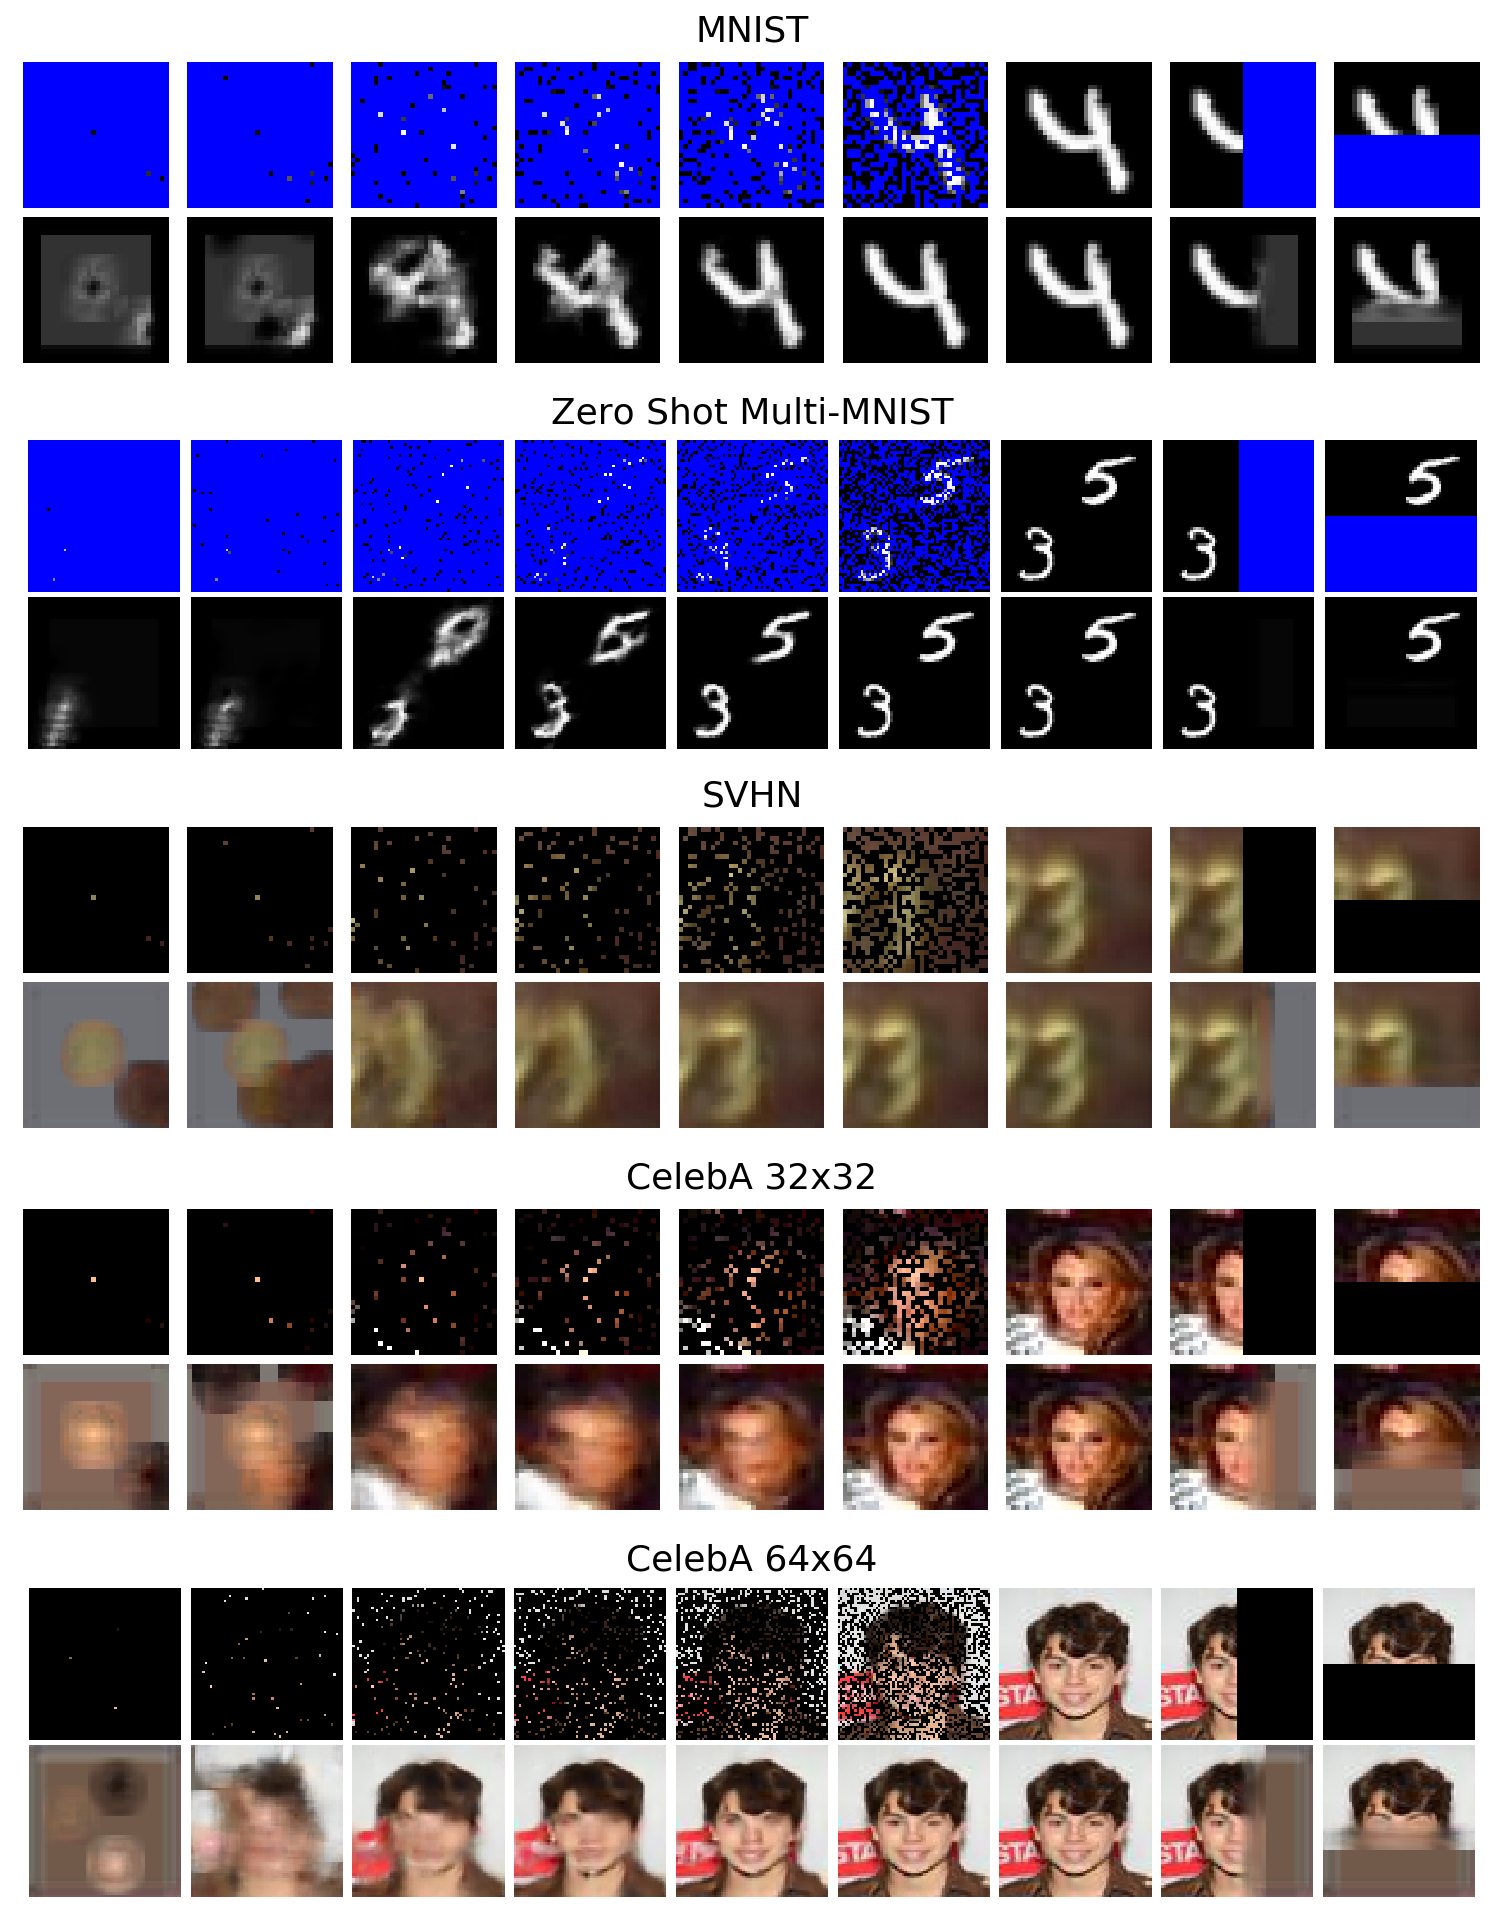

In [43]:
# Small Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=1 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

We see that it loses translation equivariance

## Will Not Mention But Interesting
- Autoregressive is hard to make work for colored images because it gets one channel off by a little and then diverges. I.e. variance is too high even if expectation might be good.
- Training with autoregressive helps a little but not much (+ the results are bad when not testing with AR)
- Training with autoregressive where the mask used is a learned function inversely proportional to the predicted variance works best, but still the results are not much better than in the non AR.


Autoregessive examples:

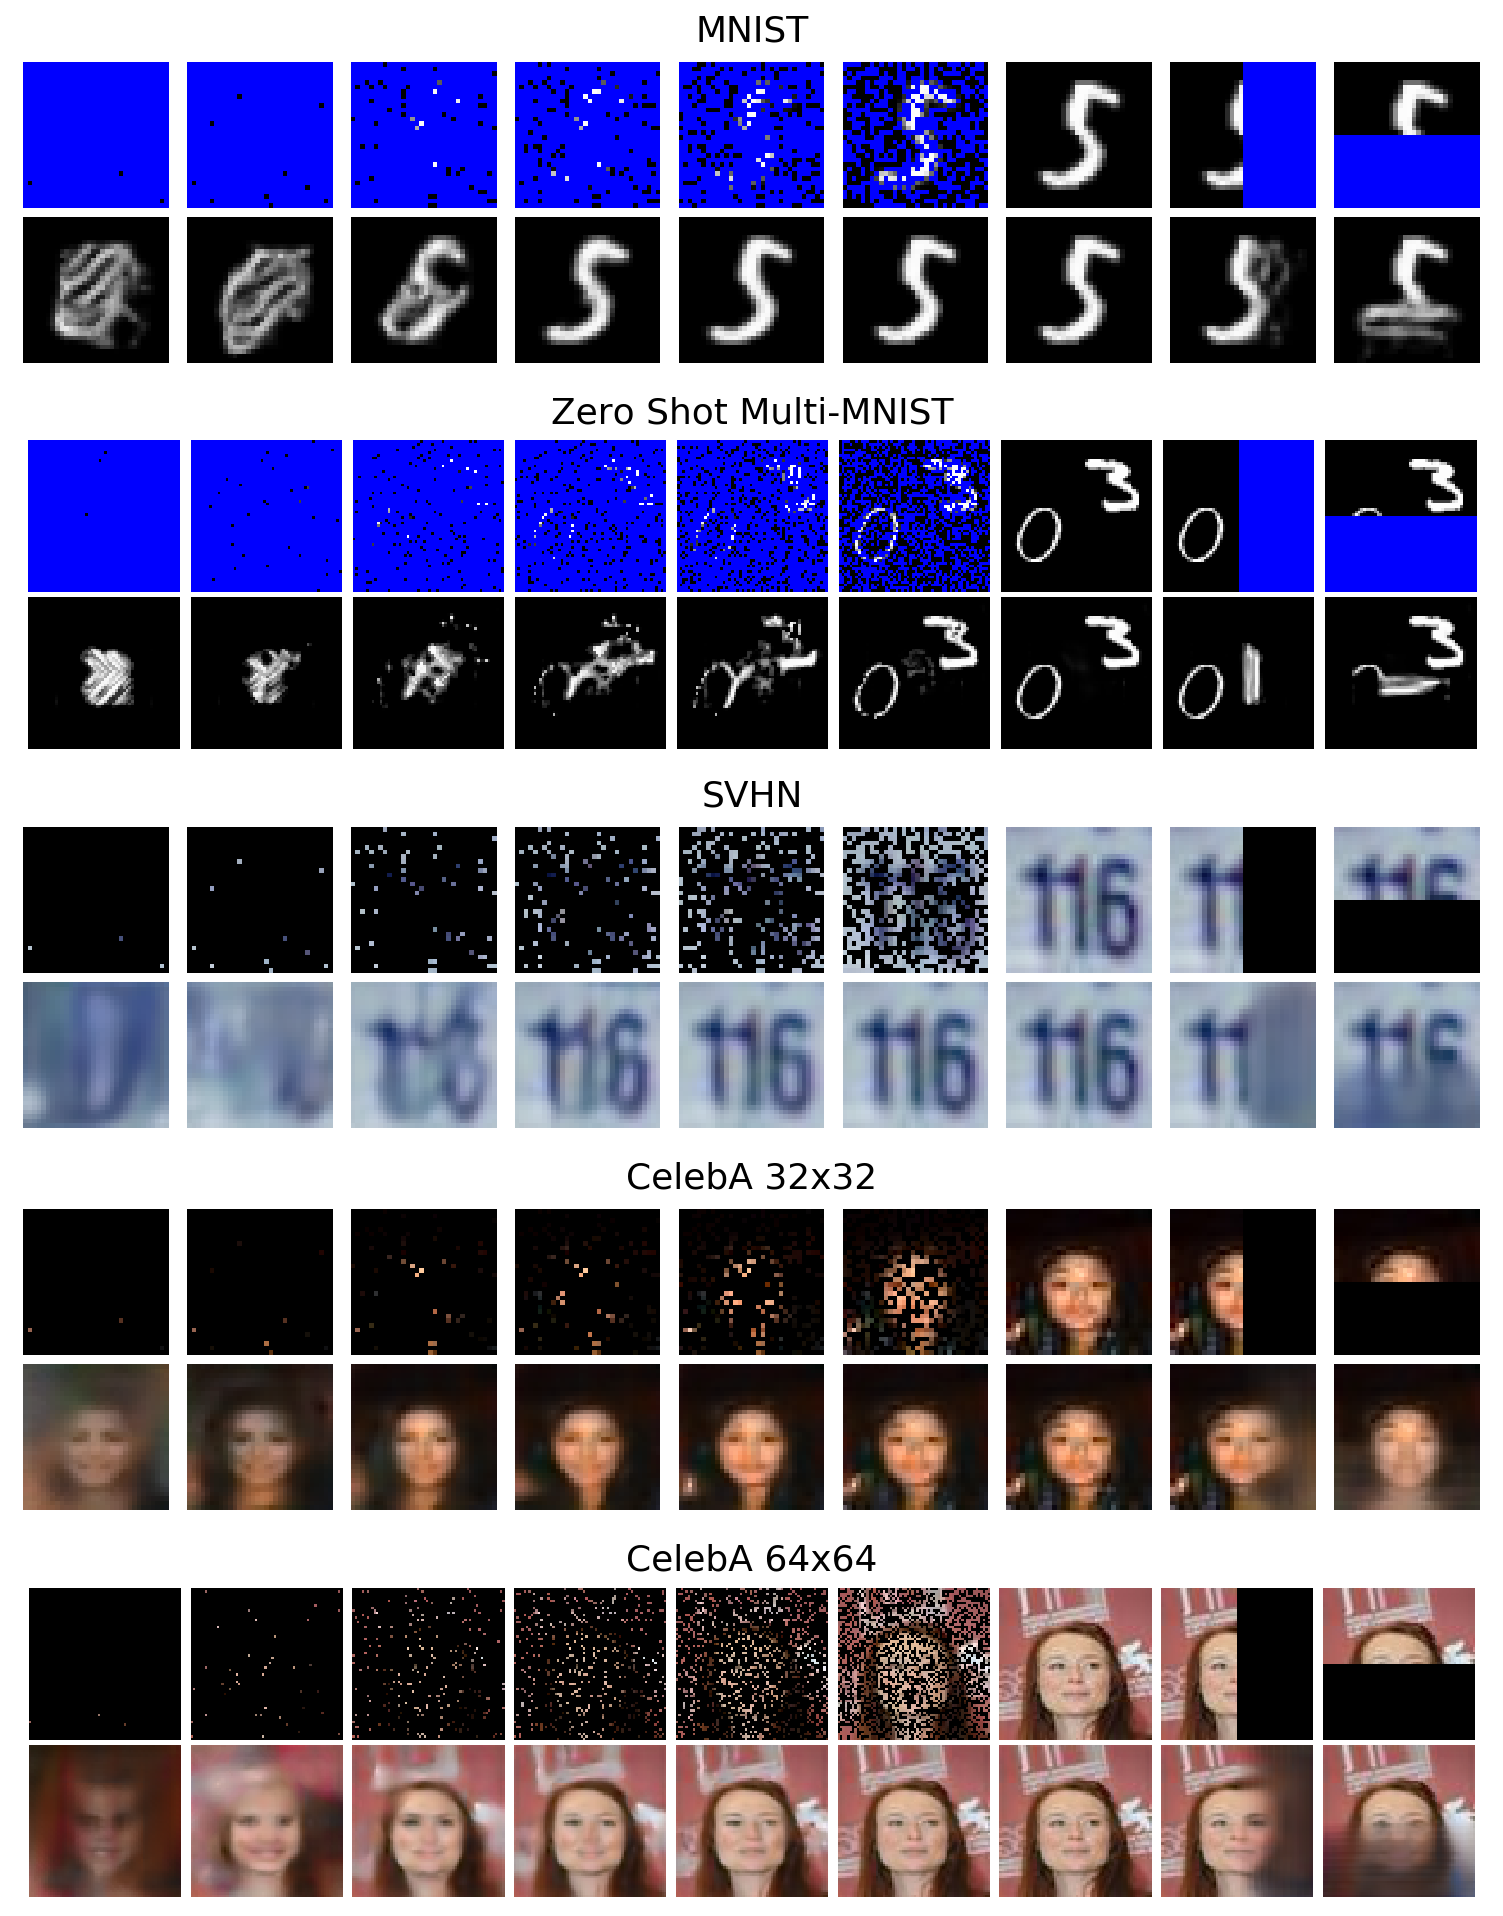

In [44]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1

# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}_large/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=partial(AutoregressivePredictor,
                                                            gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)





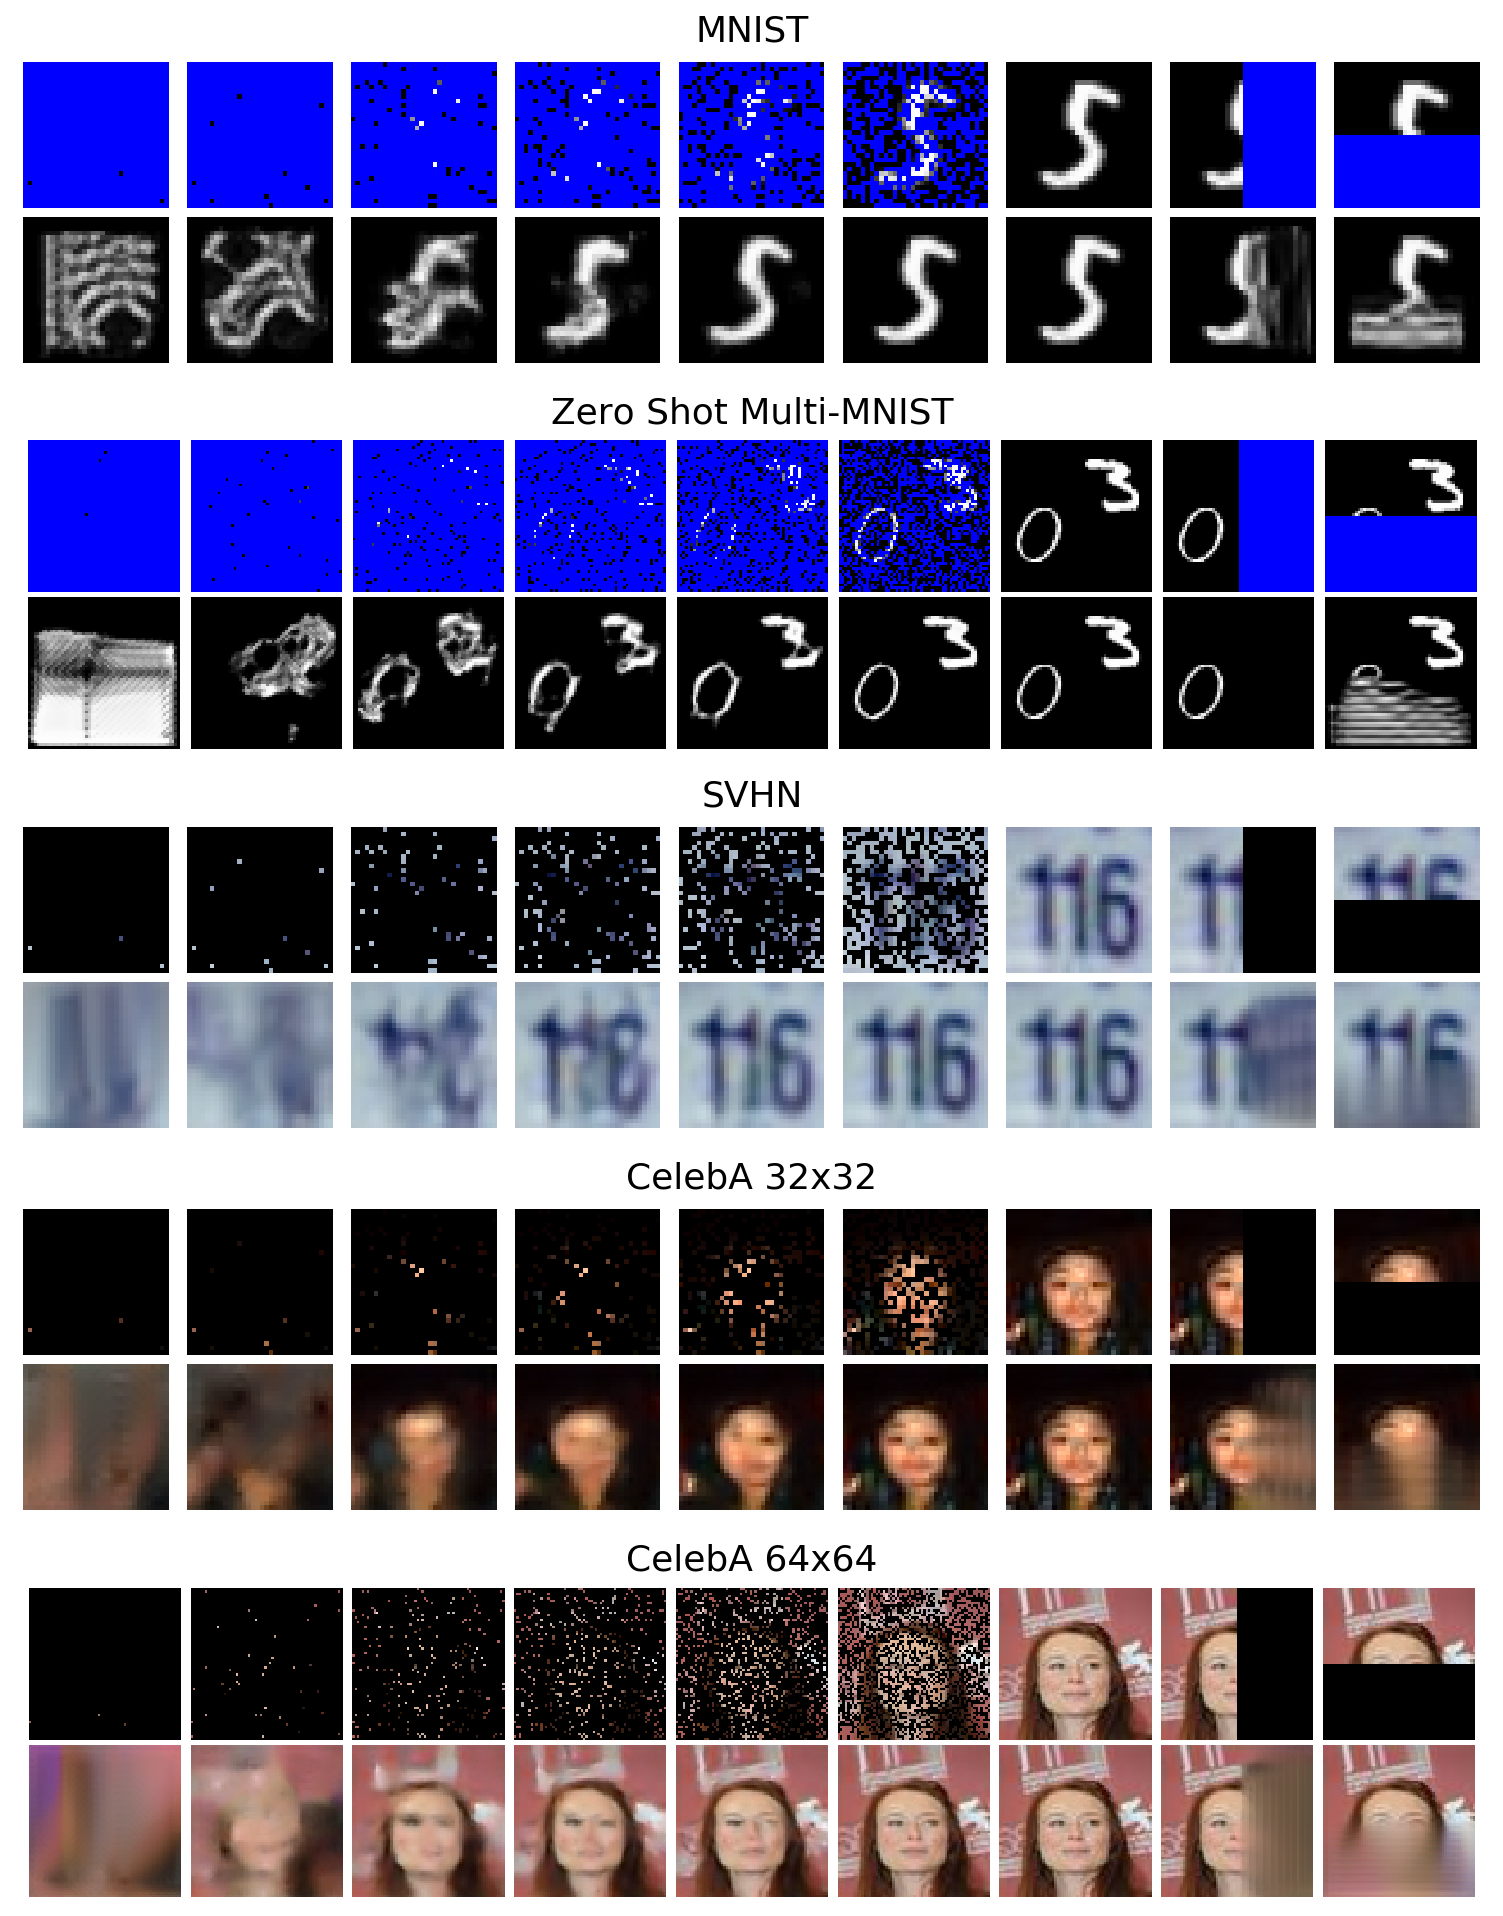

In [45]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1

# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=partial(AutoregressivePredictor,
                                                            gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)




